# Python Multithreading vs Multiprocessing vs AsyncIO

Python offers many different mechanisms to write concurrent code, but which is best?

To compare, we take a toy web crawler, make it concurrent by applying multithreading, multi-processing and asyncio coroutines, and compare performance.

Our baseline is the following non-concurrent, recursive implementation:


```python
def crawl(root: str) -> None:
    seen: set[str] = set()
    with requests.Session() as session:
        def crawl(url: str) -> None:
            print(f'processing {url}')
            html = session.get(url).content
            soup = BeautifulSoup(html)
            paths = {urljoin(url, a.get('href')) for a in soup.find_all('a')}
            for u in filter(lambda p: p.startswith(root) and p.endswith('/'), paths - seen):
                seen.add(u)
                crawl(u)

        crawl(root)
```

<Axes: title={'center': 'Python web crawler concurrency benchmark'}, xlabel='concurrency', ylabel='pages/sec'>

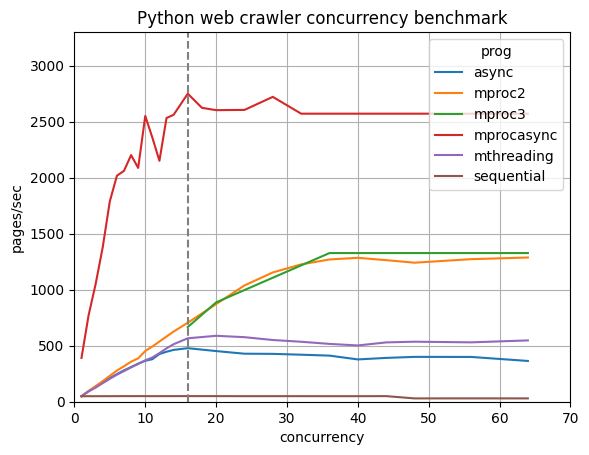

In [24]:
import pandas

pandas.set_option('display.max_rows', 500)

df = pandas.read_csv('results.csv')
df = df.sort_values(by=['prog'])
df['speed'] = df['urls'] / df['time']
df = df.sort_values(by=['prog', 'concurrency'])

# Pick the highest speed for each prog and concurrency combination:
df = df.groupby(['concurrency', 'prog'])[['speed']].max()
df = df.reset_index()
max_x = int(df['concurrency'].max() * 1.1)
max_y = int(df['speed'].max() * 1.2)
df = df.set_index('concurrency')
df = df.pivot_table('speed', ['concurrency'], 'prog')
df = df.interpolate()

ax = df.plot(grid=True, xlim=(0, max_x), ylim=(0, max_y), title='Python web crawler concurrency benchmark', ylabel='pages/sec')
# A dotted line at 16, the number of logical CPU cores during the benchmark:
ax.axvline(16, color="grey", linestyle="--")
ax

In [17]:
display(df)

prog,async,mproc2,mproc3,mprocasync,mthreading,sequential
concurrency,,,,,,
1,49.259430,49.548516,NaN,391.151071,48.650815,48.659589
2,94.129987,95.123155,NaN,770.842336,91.810499,49.422745
3,132.849683,140.020987,NaN,1051.314447,126.137767,49.426558
4,173.269321,184.195678,NaN,1380.117823,165.873559,49.436291
5,211.212044,231.372924,NaN,1788.965832,204.800826,49.614379
6,246.729567,278.168018,NaN,2017.219477,241.164200,49.728925
7,280.194621,316.573959,NaN,2060.938912,273.351667,50.061604
8,309.610967,357.565811,NaN,2201.323655,306.456135,49.908525
9,339.768929,386.960136,NaN,2086.975413,337.028125,50.102175
